Vitals before pivot: (25248, 16)
Pivot shape: (16268, 6)
Pivot columns: Index(['subject_id', 'charttime', 'diastolic_bp', 'heart_rate', 'spo2',
       'systolic_bp'],
      dtype='object', name='label')
✅ Data ready for training: (16268, 6)


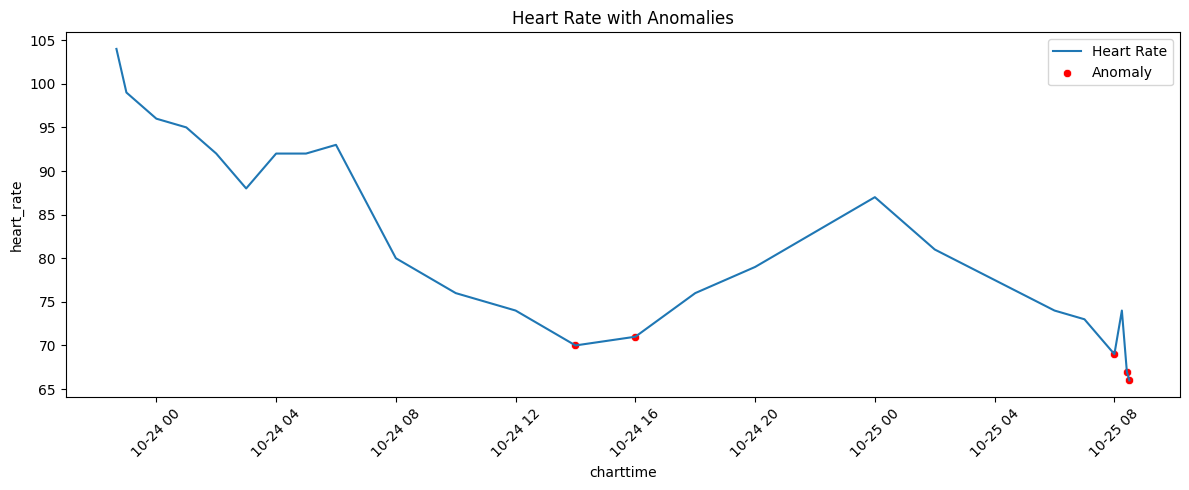

✅ Model and scaler saved in model_training/


In [22]:
# 1. Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import joblib

# 2. Load demo data (from MIMIC-III)
file_path = "../mimic_demo_data/chartevents.csv"  # Adjust path if needed
df = pd.read_csv(file_path, low_memory=False)

# 3. Filter only rows with relevant ITEMIDs (demo ITEMIDs for vitals)
vital_ids = {
    211: "heart_rate",
    220045: "spo2",
    220179: "systolic_bp",
    220180: "diastolic_bp",
}

vitals = df[df["itemid"].isin(vital_ids.keys())].copy()
vitals["label"] = vitals["itemid"].map(vital_ids)
vitals["charttime"] = pd.to_datetime(vitals["charttime"])
vitals["valuenum"] = pd.to_numeric(vitals["valuenum"], errors="coerce")

vitals.dropna(subset=["valuenum"], inplace=True)

print("Vitals before pivot:", vitals.shape)


# 4. Pivot data: One row per time per patient
pivot = vitals.pivot_table(
    index=["subject_id", "charttime"],
    columns="label",
    values="valuenum",   # ✅ updated from VALUENUM
    aggfunc="mean"
).reset_index()

print("Pivot shape:", pivot.shape)
print("Pivot columns:", pivot.columns)

if pivot.empty:
    print("❌ No data left after filtering and pivoting. Please inspect intermediate steps.")
else:
    print("✅ Data ready for training:", pivot.shape)


# 5. Drop rows with missing vitals
pivot.dropna(thresh=3, inplace=True)  # Allow one missing value


# 6. Prepare features
features = ["heart_rate", "spo2", "systolic_bp", "diastolic_bp"]
X = pivot[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Train Isolation Forest
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_scaled)

# 8. Predict anomalies
pivot["anomaly"] = model.predict(X_scaled)  # -1 = anomaly
pivot["anomaly_score"] = model.decision_function(X_scaled)

# 9. Plot for one patient
sample_subject = pivot["subject_id"].iloc[0]
sample = pivot[pivot["subject_id"] == sample_subject]

plt.figure(figsize=(12, 5))
sns.lineplot(data=sample, x="charttime", y="heart_rate", label="Heart Rate")
sns.scatterplot(
    data=sample[sample["anomaly"] == -1],
    x="charttime", y="heart_rate",
    color="red", label="Anomaly"
)
plt.xticks(rotation=45)
plt.title("Heart Rate with Anomalies")
plt.tight_layout()
plt.show()

# 10. Save the model and scaler for backend use
joblib.dump(model, "../backend/ml_models/isolation_forest_model.pkl")
joblib.dump(scaler, "../backend/ml_models/scaler.pkl")

print("✅ Model and scaler saved in model_training/")


In [23]:
# Inject artificial extreme outliers
synthetic_anomalies = pd.DataFrame({
    "heart_rate": [200, 180, 30, 25],
    "spo2": [70, 65, 60, 50],
    "systolic_bp": [210, 230, 85, 260],
    "diastolic_bp": [120, 130, 40, 160]
})

# Combine real and synthetic data
X_combined = pd.concat([X, synthetic_anomalies], ignore_index=True)

# Normalize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)


In [24]:
from sklearn.ensemble import IsolationForest
import joblib

model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_scaled)

# ✅ Save to your desired path (as you moved it)
joblib.dump(model, "../backend/ml_models/isolation_forest_model.pkl")
joblib.dump(scaler, "../backend/ml_models/scaler.pkl")

print("✅ Model and Scaler saved successfully.")


✅ Model and Scaler saved successfully.
